In [1]:
import sys
sys.path.insert(0, '..')
# from transformer.models import DecoderOnlyModel
from data_utils.Datasets import SerializedConcatDataset, PermSerializedConcatDataset, BinarySerializer
import pickle
import torch
import numpy as np

from transformers import AutoConfig, GPT2LMHeadModel

from bertviz import model_view

import matplotlib.pyplot as plt
import networkx as nx

import pandas
from collections import Counter

In [2]:
with open('serializer.pkl', 'rb') as inp:
    binser = pickle.load(inp)

binser2 = BinarySerializer()

# define model
vocab_size = binser.vocab_size
d_model = 256
num_heads = 4
num_layers = 4
d_ff = 256
max_seq_length = binser.max_seq_length
dropout = 0.3

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=vocab_size,
    n_positions=max_seq_length,
    n_layer=num_layers,
    n_head=num_heads,
    pad_token_id=binser.padding,
    bos_token_id=binser.padding,
    eos_token_id=binser.padding,
    n_embd=d_ff
)
transformer = GPT2LMHeadModel(config).to(dev)

transformer = transformer.to(dev)

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transformer = transformer.to(dev)

saved_model_path = '../saved_models/melboost_GPT2_serialized/melboost_GPT2_serialized.pt'
transformer.load_state_dict(torch.load(saved_model_path), strict=False)

transformer.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30, 256)
    (wpe): Embedding(1063, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=30, bias=False)
)

In [3]:
# load data to test
# load data
npz_path = '../data/augmented_and_padded_data.npz'
dataset = SerializedConcatDataset(npz_path, pad_to_length=max_seq_length)

In [6]:
x, mask = dataset.__getitem__(0)
# find start harmonization index
idx = np.where(x == binser.start_harmonizing)[0][0]
print(idx)
y = np.pad(x[:idx+1], (x.shape[0]-idx-1, 0))
# print(x.shape)
# print(y.shape)
with np.printoptions(threshold=np.inf):
    print(mask)
    print(x)
    print(y)

784
[-100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100 -100
 -

In [61]:
x, mask = dataset.__getitem__(2)
# find start harmonization index
idx = np.where(x == binser.start_harmonizing)[0][0]
# print(idx)
y = np.pad(x[:idx+1], (x.shape[0]-idx-1, 0))
# remove zeros from the beginning and append them to the end
idx = np.where(y == binser.start_melody)[0][0]
y = np.roll(y, -idx)
idx = np.where(x == binser.start_melody)[0][0]
x = np.roll(x, -idx)
# print(x.shape)
# print(y.shape)
# with np.printoptions(threshold=np.inf):
#     print(x)
#     print(y)

In [6]:
# inp = torch.from_numpy( np.expand_dims(y[1:], axis=0)).to(dev)
# inp = torch.from_numpy( np.expand_dims(y[:-1], axis=0)).to(dev)
inp = torch.from_numpy( np.expand_dims(x[:-1], axis=0)).to(dev)
with np.printoptions(threshold=np.inf):
    print(inp.cpu().numpy())
output = transformer(inp, attention_mask=inp != 0, output_attentions=True)
curr_idx = np.where(inp.cpu() == binser.start_harmonizing)[1][0]
print(curr_idx)

[[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
   2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
  14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
   3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
   2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
   7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2 15 16 17 19 22 26 16
  19 22 24 28 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26
  16 19 21 24 28 16 18 21 24 26 16 17 19 22 26 16 19 22 24 28 16 17 19 22
  26 16 19 22 24 28 16 17 21 24 28 16 17 21 24 28 16 18 21 23 26 16 20 23
  26 28 16 18 21 23 26 16 20 23 26 28 16 20 21 25 28 16 18 21 24 26 16 20
  23 25 28 16 18 22 25 28 16 18 21 23 26 16 20 23 26 28 16 18 21 23 26 16
  20 23 26 28 16 20 21 25 28 16 19 22 24 28 16 17 19 22 26 16 19 22 24 28
  16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26 16 19 21 24
  28 16 18 21 24 26 16 17 19 22 26 16 

In [63]:
prediction = output.logits.argmax(dim=2, keepdim=True).squeeze()
z = prediction.cpu().numpy()
# with np.printoptions(threshold=np.inf):
#     print(z)
# print(z[curr_idx])

In [8]:
a = output.attentions
# non-padded matrix
idx_pad = np.where(x == 0)[0][0]
idx_harm = np.where(x == binser.start_harmonizing)[0][0]
x_useful = x[:idx_pad]
tokens = binser2.indexes2labels( x_useful )
# non_padded attention
nonpadded_attention = []
for l in range(len(a)):
    nonpadded_attention.append( a[l][:,:,:idx_pad,:idx_pad] )

In [9]:
print(a[0].shape)
print(nonpadded_attention[0].shape)
print(idx_harm)
print(x[:idx_harm])
print(x_useful)
print(tokens)

torch.Size([1, 4, 1062, 1062])
torch.Size([1, 4, 416, 416])
137
[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
  2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
 14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
  2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
  7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2]
[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
  2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
 14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
  2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
  7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2 15 16 17 19 22 26 16
 19 22 24 28 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26
 16 19 

<Axes: >

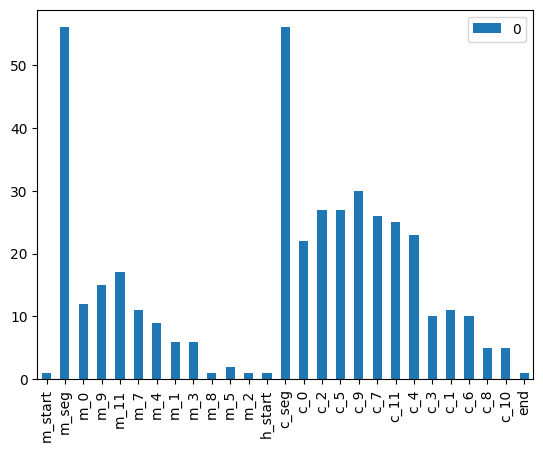

In [62]:
tokens_counts = Counter(tokens)
df = pandas.DataFrame.from_dict(tokens_counts, orient='index')
df.plot(kind='bar')

In [25]:
# crashes, probably because of sentence size...
# model_view(nonpadded_attention, tokens)
xx = np.array([ [1,2,3], [4,5,6], [7,8,9] ])
print(xx)
xxm = np.mean(xx, axis=1)
print(xxm)
print(xx > xxm[:,None])

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[2. 5. 8.]
[[False False  True]
 [False False  True]
 [False False  True]]


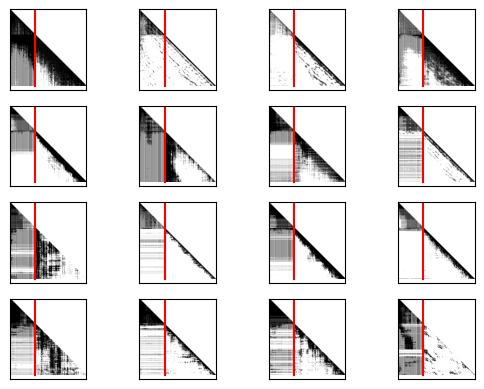

In [26]:
for l in range(4):
    for h in range(4):
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        # print( np.sum(a_np, axis=1) ) # indeed add to 1
        plt.subplot(4,4,4*l+h+1)
        # find mean per row
        m = np.mean( a_np, axis=1 )
        # plot values in each row larger than the values in each row
        plt.imshow( a_np > m[:,None], cmap='gray_r' )
        plt.plot([idx_harm, idx_harm],[0, idx_pad], 'r')
        plt.xticks([])
        plt.yticks([])

In [12]:
a_np = a[2][0,0,:idx_pad,:idx_pad].cpu().detach().numpy()
# delete diagonal
np.fill_diagonal(a_np, 0)
print(x_useful)
r = ( np.mean(a_np[x_useful == 2, :], axis=0) )
print(np.logical_and( x_useful == 12, x_useful >= idx_harm ))

[ 1  2  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12
  2 14  2  3 12  2 10 14  2  7  2  7  2  4  7  2  6  2  4  7  2  6  2  6
 14  2  4  2  6 14  2  4  2  4  7  2  6  2  4  7  2  6 14  2 11  2 10  2
  3 12  2 14  2  3 12  2 14  2 10 14  2 12  2 10 14  2 12  2  3 12  2 14
  2  3 12  2 10 14  2 10  2 10  2 12  2 10  2  8  2  7  2 10  2  8  2  5
  7  2  3 12  2 14  2  3 12  2  7 14  2  3  2  3  2 15 16 17 19 22 26 16
 19 22 24 28 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26
 16 19 21 24 28 16 18 21 24 26 16 17 19 22 26 16 19 22 24 28 16 17 19 22
 26 16 19 22 24 28 16 17 21 24 28 16 17 21 24 28 16 18 21 23 26 16 20 23
 26 28 16 18 21 23 26 16 20 23 26 28 16 20 21 25 28 16 18 21 24 26 16 20
 23 25 28 16 18 22 25 28 16 18 21 23 26 16 20 23 26 28 16 18 21 23 26 16
 20 23 26 28 16 20 21 25 28 16 19 22 24 28 16 17 19 22 26 16 19 22 24 28
 16 17 19 22 26 16 19 22 24 28 16 17 21 24 28 16 17 20 22 26 16 19 21 24
 28 16 18 21 24 26 16 17 19 22 26 16 19 22 24 28 16

In [13]:
labels = binser2.indexes2labels( x[:idx_pad] )

# not considering pad - no pad in the sequence
labels_dict = {k: binser2.indexes2labels([k])[0] for k in range(binser2.vocab_size)}
print(labels_dict)

{0: 'pad', 1: 'm_start', 2: 'm_seg', 3: 'm_0', 4: 'm_1', 5: 'm_2', 6: 'm_3', 7: 'm_4', 8: 'm_5', 9: 'm_6', 10: 'm_7', 11: 'm_8', 12: 'm_9', 13: 'm_10', 14: 'm_11', 15: 'h_start', 16: 'c_seg', 17: 'c_0', 18: 'c_1', 19: 'c_2', 20: 'c_3', 21: 'c_4', 22: 'c_5', 23: 'c_6', 24: 'c_7', 25: 'c_8', 26: 'c_9', 27: 'c_10', 28: 'c_11', 29: 'end'}


(30, 30)


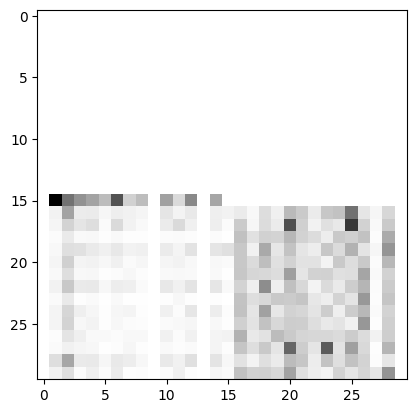

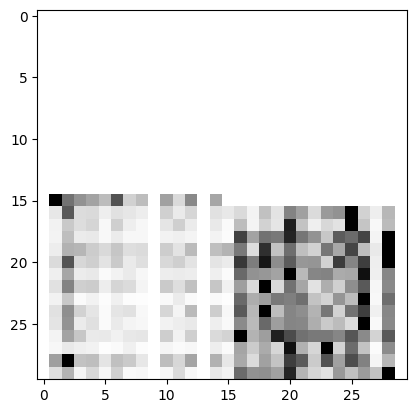

In [43]:
# reduce matrix
a_np = a[3][0,0,:idx_pad,:idx_pad].cpu().detach().numpy()

def reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=None):
    # delete diagonal
    if neutralize_diagonal:
        np.fill_diagonal(a_np, 0)
    if idx_harm is not None:
        # delete attention between melody parts
        a_np[:idx_harm, :idx_harm] = 0
    # initialize labels
    labels = []
    # first reduce rows
    row_reduced_attention = []
    for i in range(binser2.vocab_size):
        if i in x_useful:
            row_reduced_attention.append( np.mean(a_np[x_useful == i, :], axis=0) )
            labels.append( binser2.indexes2labels( [i] )[0] )
        else:
            row_reduced_attention.append( np.zeros( a_np.shape[1] ) )
    row_reduced_attention = np.array(row_reduced_attention)
    # reduce columns
    reduced_attention = []
    for i in range(binser2.vocab_size):
        if i in x_useful:
            reduced_attention.append( np.mean(row_reduced_attention[:, x_useful == i], axis=1) )
        else:
            reduced_attention.append( np.zeros( row_reduced_attention.shape[0] ) )
    return np.array(reduced_attention).T
# end reduce_attention

def norm_reduce_attention( a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=None ):
    reduced_attention = reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
    rows_max = np.amax(reduced_attention, axis=1)
    rows_max[rows_max == 0] = 1
    norm_reduced_attention = reduced_attention/rows_max[:,None]
    return norm_reduced_attention
# end norm_reduce_attention

reduced_attention = reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)

print(reduced_attention.shape)
# plt.imshow( reduced_attention > np.mean(reduced_attention), cmap='gray_r' )
plt.imshow( reduced_attention , cmap='gray_r' )
plt.show()
# plt.xticks([])
# plt.yticks([])

norm_reduced_attention = norm_reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
plt.imshow( norm_reduced_attention , cmap='gray_r' )
plt.show()

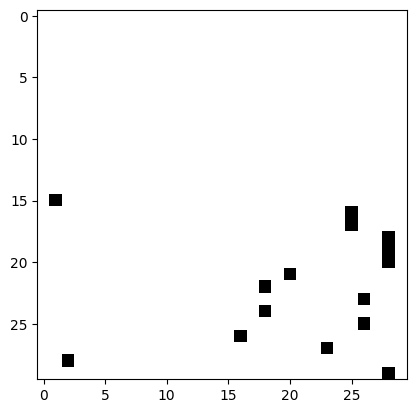

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29] [ 1 25 25 28 28 28 20 18 26 18 26 16 23  2 28]
[(15, 1), (16, 25), (17, 25), (18, 28), (19, 28), (20, 28), (21, 20), (22, 18), (23, 26), (24, 18), (25, 26), (26, 16), (27, 23), (28, 2), (29, 28)]


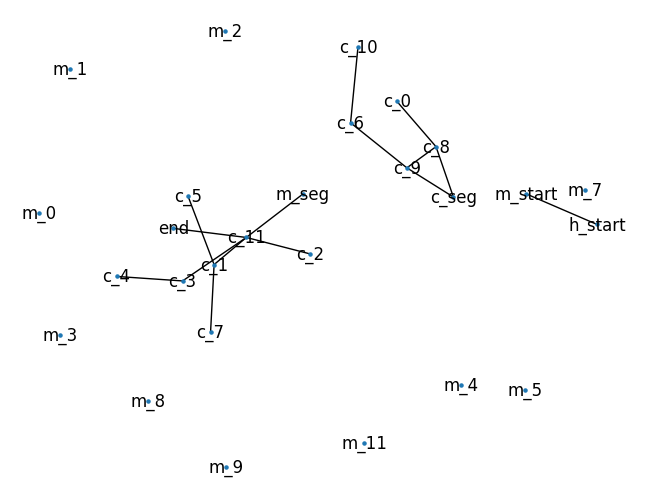

In [46]:
def make_attention_graph(att, labels_dict, m_th=10):
    m_value = np.sort( att.ravel() )[:-m_th:-1][-1]
    
    adjacency_matrix = att >= m_value
    
    plt.imshow(adjacency_matrix, cmap='gray_r')
    plt.show()
    
    rows, cols = np.where(adjacency_matrix == 1)
    print(rows, cols)
    edges = zip(rows.tolist(), cols.tolist())
    edges_list = list(zip(rows.tolist(), cols.tolist()))
    print(edges_list)
    
    gr = nx.Graph()
    gr.add_nodes_from( labels )
    for edge_idxs in edges_list:
        gr.add_edge( labels_dict[edge_idxs[0]] , labels_dict[edge_idxs[1]] )
    return adjacency_matrix, gr
# end make_attention_graph

adjacency_matrix, gr = make_attention_graph(norm_reduced_attention, labels_dict, m_th=10)

pos = nx.spring_layout(gr, k=0.25, iterations=20)
nx.draw(gr, pos, node_size=5, with_labels=True)
plt.show()

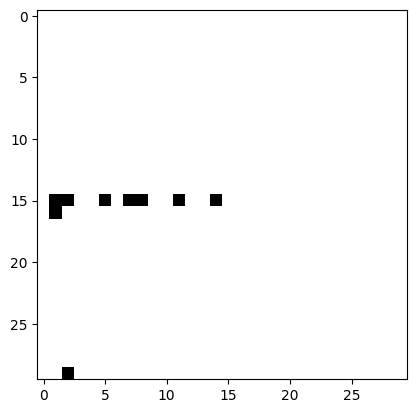

[15 15 15 15 15 15 15 16 29] [ 1  2  5  7  8 11 14  1  2]
[(15, 1), (15, 2), (15, 5), (15, 7), (15, 8), (15, 11), (15, 14), (16, 1), (29, 2)]


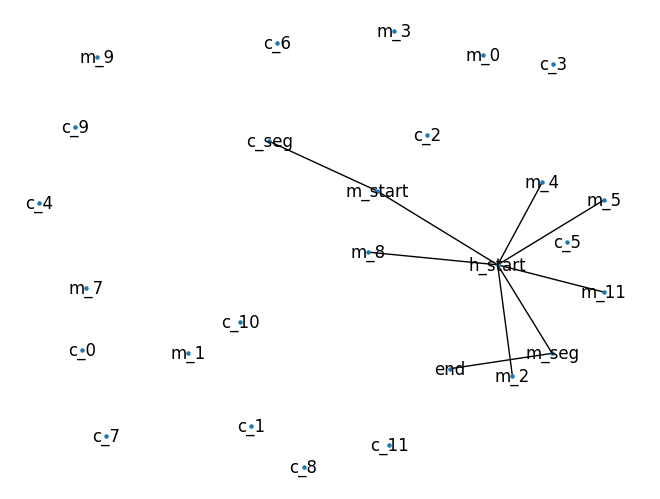

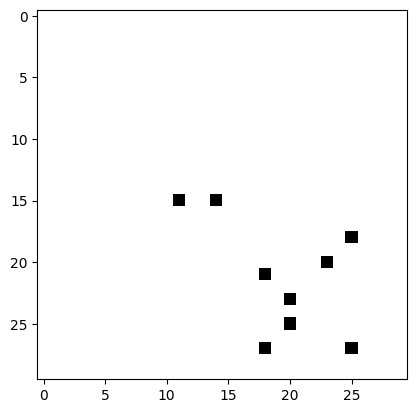

[15 15 18 20 21 23 25 27 27] [11 14 25 23 18 20 20 18 25]
[(15, 11), (15, 14), (18, 25), (20, 23), (21, 18), (23, 20), (25, 20), (27, 18), (27, 25)]


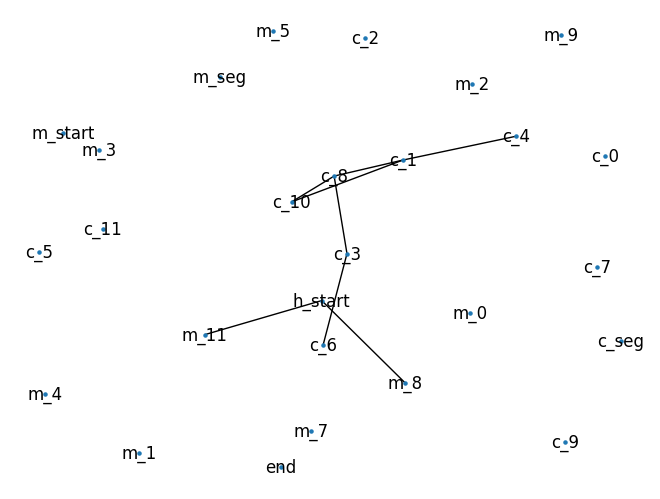

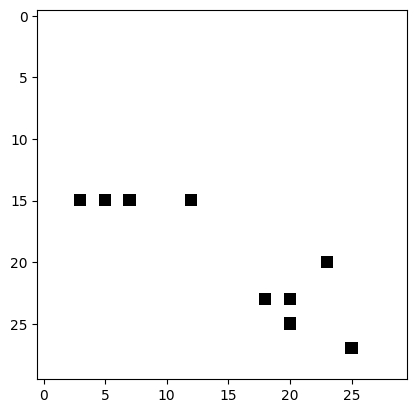

[15 15 15 15 20 23 23 25 27] [ 3  5  7 12 23 18 20 20 25]
[(15, 3), (15, 5), (15, 7), (15, 12), (20, 23), (23, 18), (23, 20), (25, 20), (27, 25)]


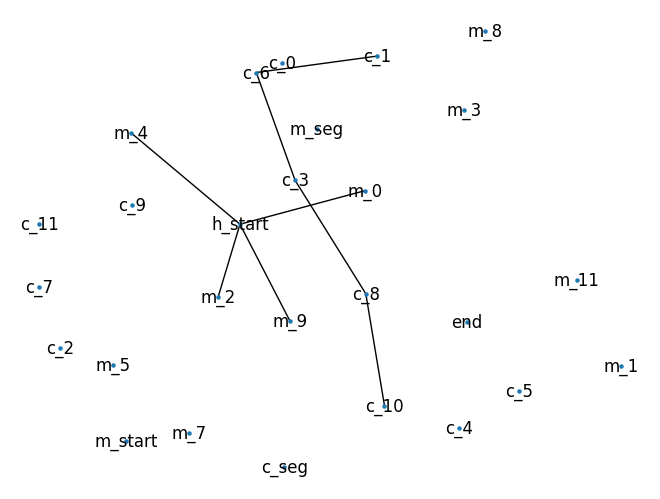

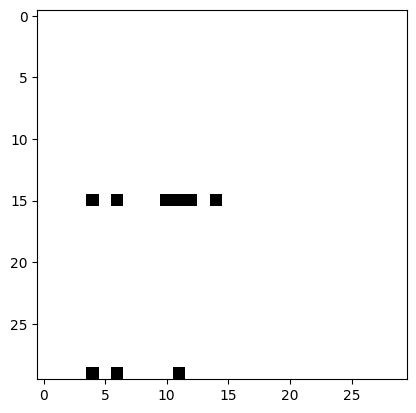

[15 15 15 15 15 15 29 29 29] [ 4  6 10 11 12 14  4  6 11]
[(15, 4), (15, 6), (15, 10), (15, 11), (15, 12), (15, 14), (29, 4), (29, 6), (29, 11)]


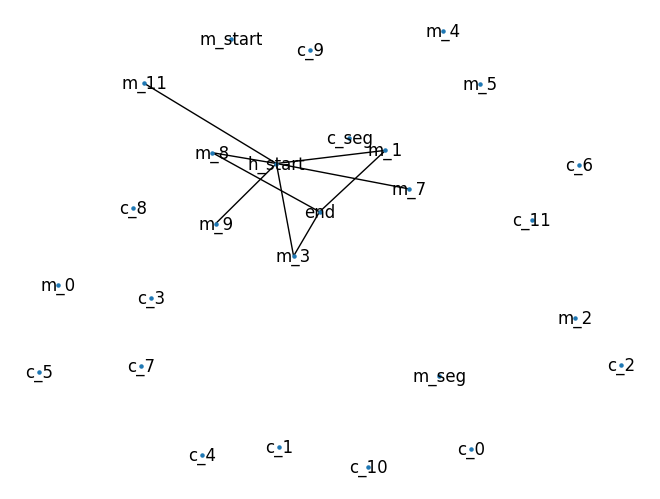

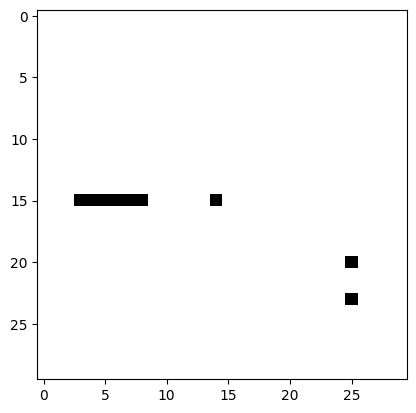

[15 15 15 15 15 15 15 20 23] [ 3  4  5  6  7  8 14 25 25]
[(15, 3), (15, 4), (15, 5), (15, 6), (15, 7), (15, 8), (15, 14), (20, 25), (23, 25)]


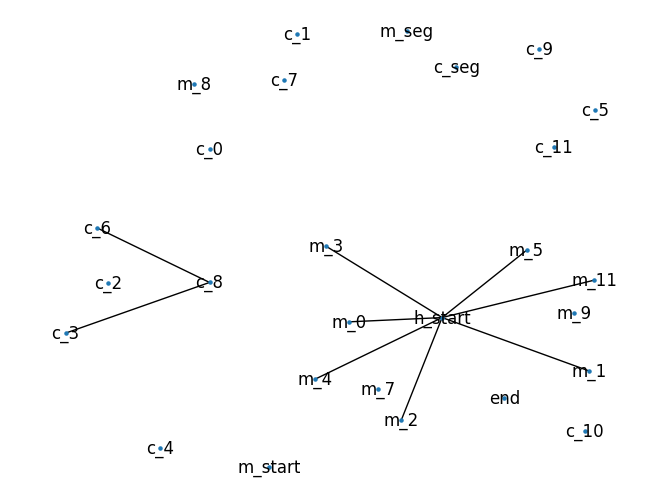

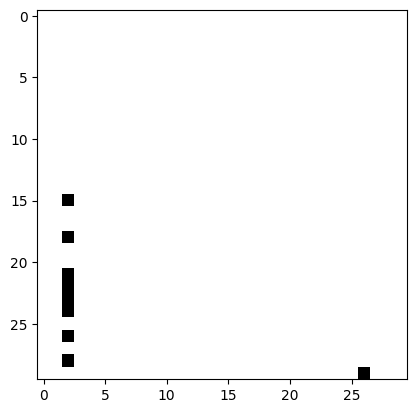

[15 18 21 22 23 24 26 28 29] [ 2  2  2  2  2  2  2  2 26]
[(15, 2), (18, 2), (21, 2), (22, 2), (23, 2), (24, 2), (26, 2), (28, 2), (29, 26)]


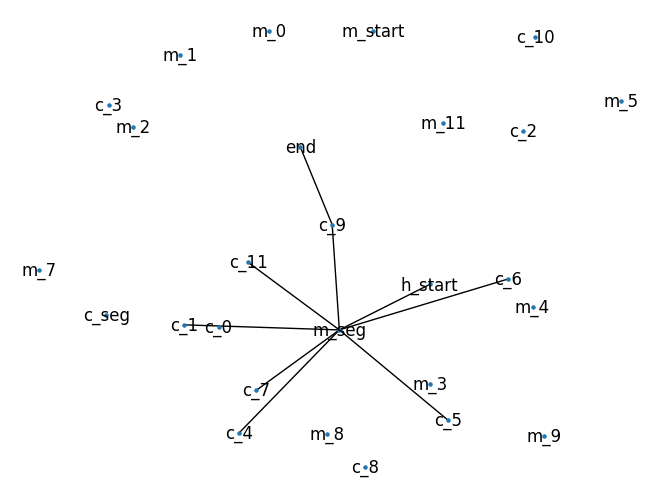

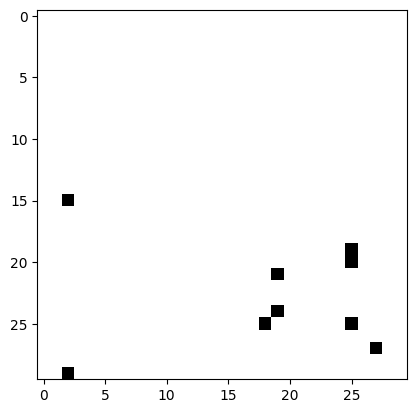

[15 19 20 21 24 25 25 27 29] [ 2 25 25 19 19 18 25 27  2]
[(15, 2), (19, 25), (20, 25), (21, 19), (24, 19), (25, 18), (25, 25), (27, 27), (29, 2)]


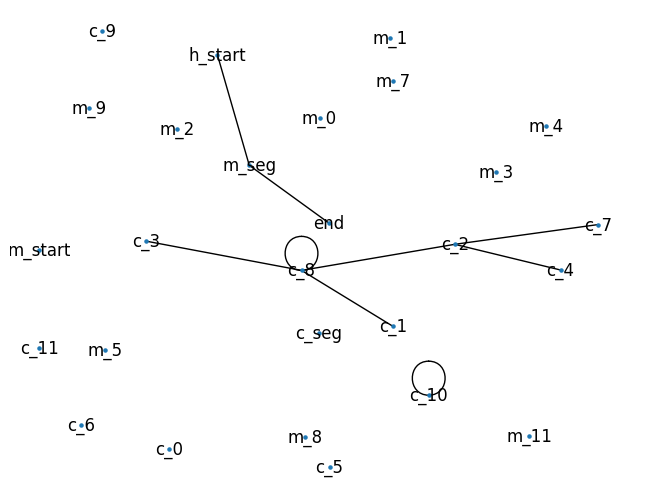

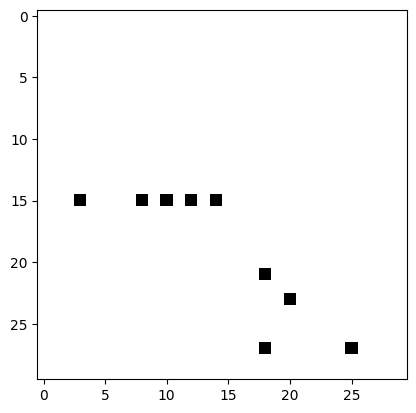

[15 15 15 15 15 21 23 27 27] [ 3  8 10 12 14 18 20 18 25]
[(15, 3), (15, 8), (15, 10), (15, 12), (15, 14), (21, 18), (23, 20), (27, 18), (27, 25)]


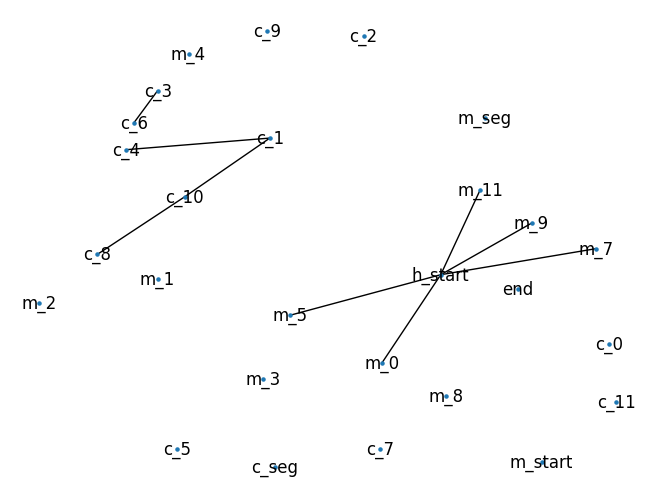

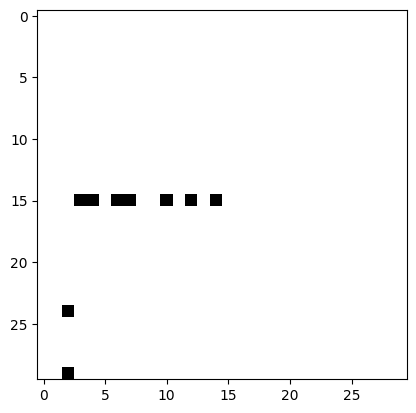

[15 15 15 15 15 15 15 24 29] [ 3  4  6  7 10 12 14  2  2]
[(15, 3), (15, 4), (15, 6), (15, 7), (15, 10), (15, 12), (15, 14), (24, 2), (29, 2)]


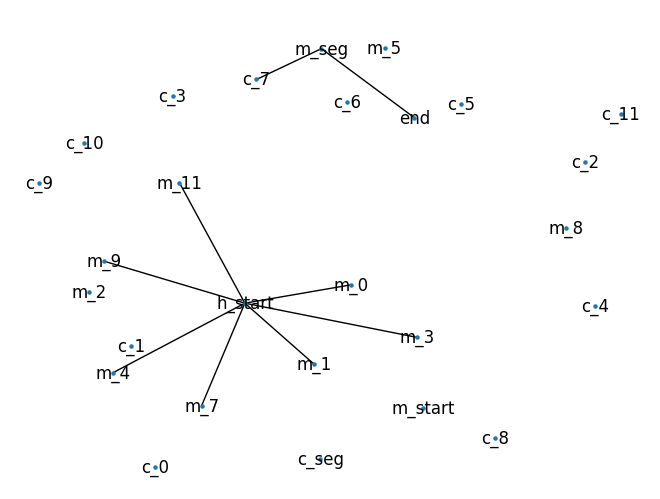

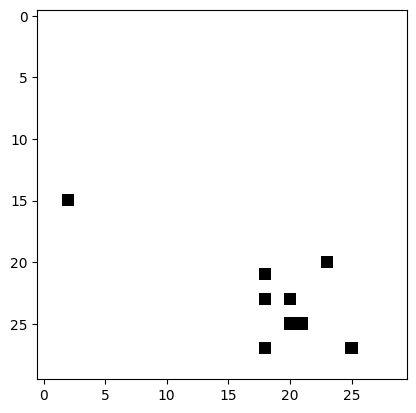

[15 20 21 23 23 25 25 27 27] [ 2 23 18 18 20 20 21 18 25]
[(15, 2), (20, 23), (21, 18), (23, 18), (23, 20), (25, 20), (25, 21), (27, 18), (27, 25)]


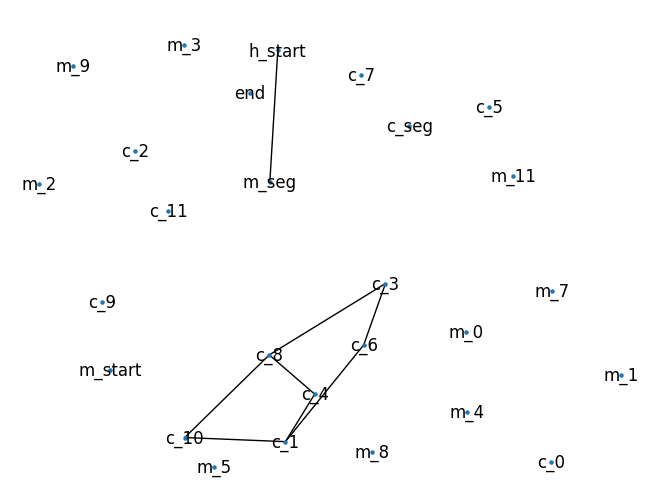

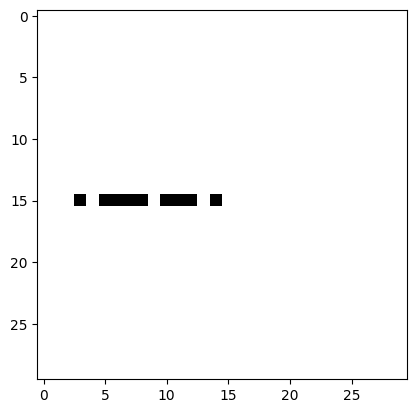

[15 15 15 15 15 15 15 15 15] [ 3  5  6  7  8 10 11 12 14]
[(15, 3), (15, 5), (15, 6), (15, 7), (15, 8), (15, 10), (15, 11), (15, 12), (15, 14)]


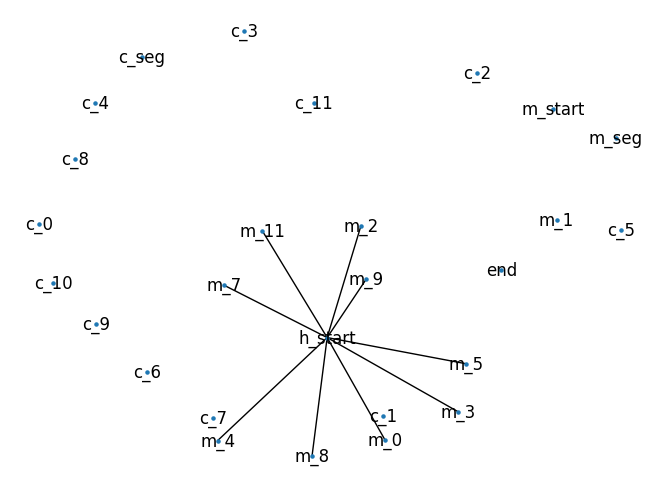

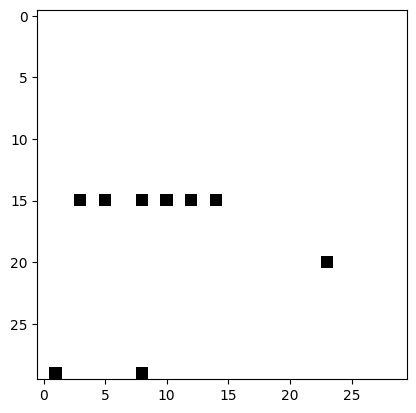

[15 15 15 15 15 15 20 29 29] [ 3  5  8 10 12 14 23  1  8]
[(15, 3), (15, 5), (15, 8), (15, 10), (15, 12), (15, 14), (20, 23), (29, 1), (29, 8)]


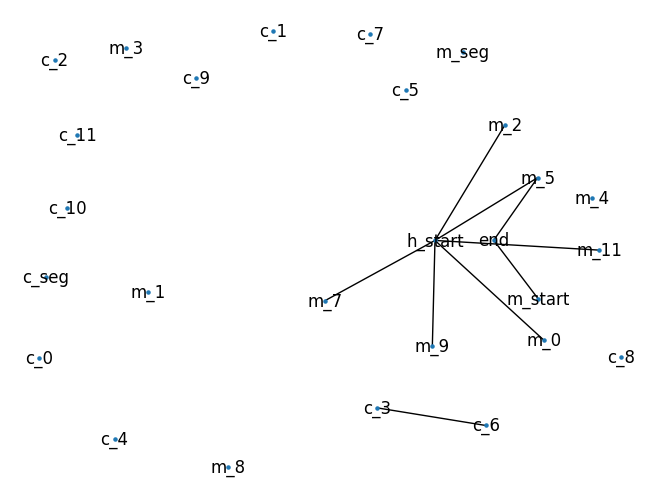

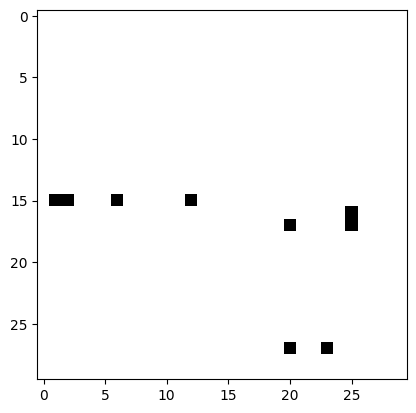

[15 15 15 15 16 17 17 27 27] [ 1  2  6 12 25 20 25 20 23]
[(15, 1), (15, 2), (15, 6), (15, 12), (16, 25), (17, 20), (17, 25), (27, 20), (27, 23)]


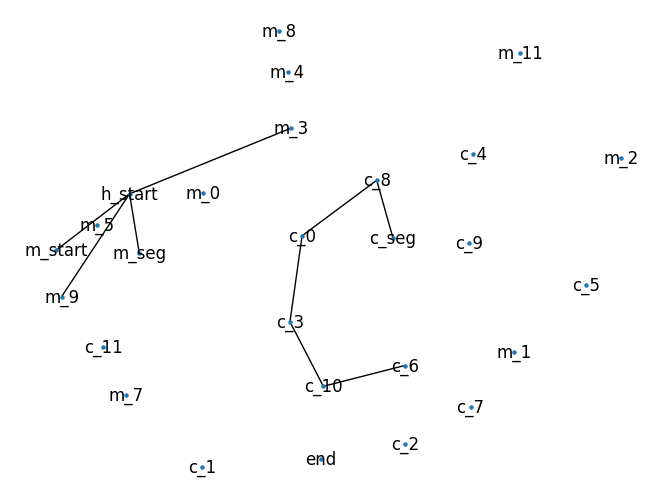

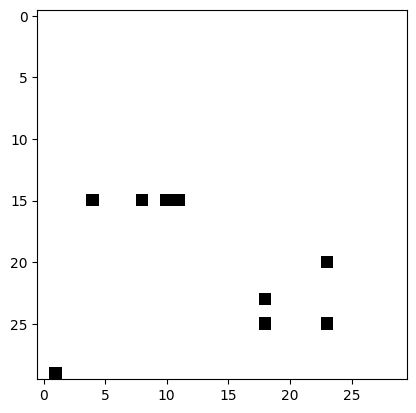

[15 15 15 15 20 23 25 25 29] [ 4  8 10 11 23 18 18 23  1]
[(15, 4), (15, 8), (15, 10), (15, 11), (20, 23), (23, 18), (25, 18), (25, 23), (29, 1)]


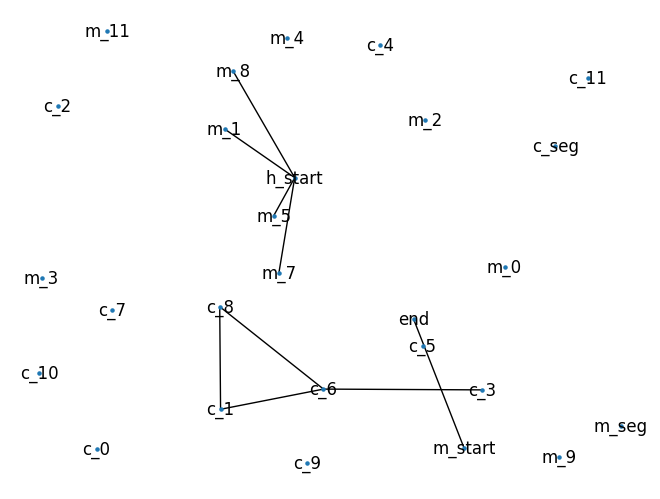

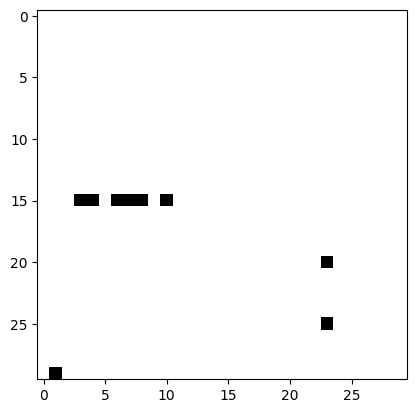

[15 15 15 15 15 15 20 25 29] [ 3  4  6  7  8 10 23 23  1]
[(15, 3), (15, 4), (15, 6), (15, 7), (15, 8), (15, 10), (20, 23), (25, 23), (29, 1)]


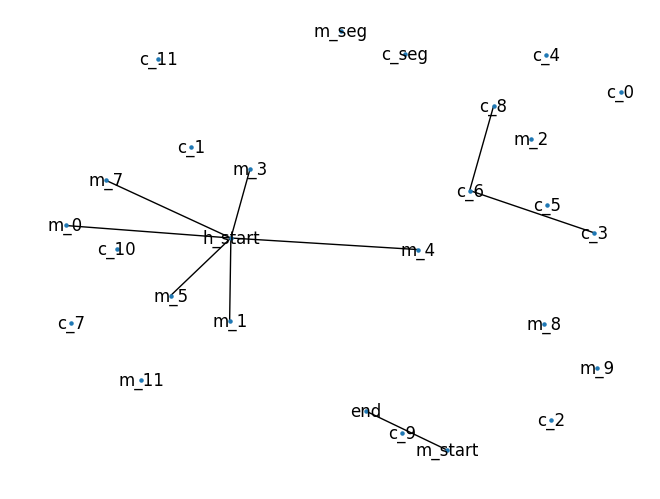

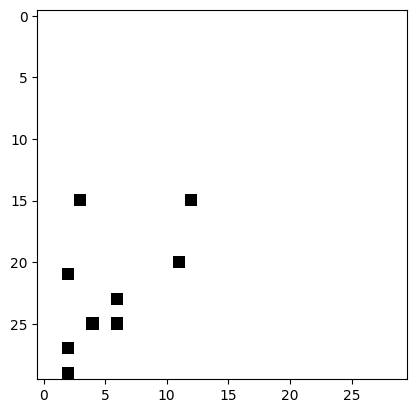

[15 15 20 21 23 25 25 27 29] [ 3 12 11  2  6  4  6  2  2]
[(15, 3), (15, 12), (20, 11), (21, 2), (23, 6), (25, 4), (25, 6), (27, 2), (29, 2)]


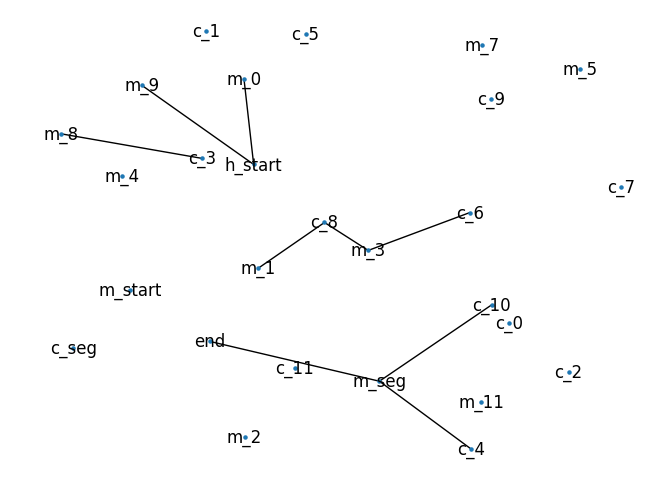

In [47]:
for l in range(4):
    for h in range(4):
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        reduced_attention = reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
        adjacency_matrix, gr = make_attention_graph(reduced_attention, labels_dict, m_th=10)
        pos = nx.spring_layout(gr, k=0.25, iterations=10)
        nx.draw(gr, pos, node_size=5, with_labels=True)
        plt.show()

In [55]:
for l in range(4):
    for h in range(4):
        # weighted graph approach
        a_np = a[l][0,h,:idx_pad,:idx_pad].cpu().detach().numpy()
        
        norm_reduced_attention = norm_reduce_attention(a_np, x_useful, labels_dict, neutralize_diagonal=True, idx_harm=idx_harm)
        plt.imshow( norm_reduced_attention , cmap='gray_r' )
        plt.savefig( 'figs/' + 'l'+str(l) + '_h'+str(h) + '_att.png', dpi=300 )
        plt.clf()

        for row in range( binser2.start_harmonizing, binser2.end_harmonizing, 1 ):
            print( str(l) + '-' + str(h) + '-' + str(row) )
            tmp_att = np.array(norm_reduced_attention)
            tmp_att[ :row ,:] = 0
            tmp_att[ row+1: ,:] = 0
            G = nx.from_numpy_array(tmp_att, create_using=nx.DiGraph)
            layout = nx.spring_layout(G, k=0.55, iterations=20)
            plt.imshow( tmp_att , cmap='gray_r' )
            plt.savefig( 'figs/' + 'l'+str(l) + '_h'+str(h) + '_r'+str(row) + '_att.png', dpi=300 )
            plt.clf()
            
            for edge in G.edges(data="weight"):
                nx.draw_networkx_edges(G, layout, edgelist=[edge], alpha = (edge[2]/np.max(tmp_att)))
            
            nx.draw_networkx_nodes(G, layout, node_size=5)
            nx.draw_networkx_labels(G,layout, labels=labels_dict)
            plt.savefig( 'figs/' + 'l'+str(l) + '_h'+str(h) + '_r'+str(row) + '_graph.png', dpi=300 )
            plt.clf()

0-0-15
0-0-16
0-0-17
0-0-18
0-0-19
0-0-20
0-0-21
0-0-22
0-0-23
0-0-24
0-0-25
0-0-26
0-0-27
0-0-28
0-1-15
0-1-16
0-1-17
0-1-18
0-1-19
0-1-20
0-1-21
0-1-22
0-1-23
0-1-24
0-1-25
0-1-26
0-1-27
0-1-28
0-2-15
0-2-16
0-2-17
0-2-18
0-2-19
0-2-20
0-2-21
0-2-22
0-2-23
0-2-24
0-2-25
0-2-26
0-2-27
0-2-28
0-3-15
0-3-16
0-3-17
0-3-18
0-3-19
0-3-20
0-3-21
0-3-22
0-3-23
0-3-24
0-3-25
0-3-26
0-3-27
0-3-28
1-0-15
1-0-16
1-0-17
1-0-18
1-0-19
1-0-20
1-0-21
1-0-22
1-0-23
1-0-24
1-0-25
1-0-26
1-0-27
1-0-28
1-1-15
1-1-16
1-1-17
1-1-18
1-1-19
1-1-20
1-1-21
1-1-22
1-1-23
1-1-24
1-1-25
1-1-26
1-1-27
1-1-28
1-2-15
1-2-16
1-2-17
1-2-18
1-2-19
1-2-20
1-2-21
1-2-22
1-2-23
1-2-24
1-2-25
1-2-26
1-2-27
1-2-28
1-3-15
1-3-16
1-3-17
1-3-18
1-3-19
1-3-20
1-3-21
1-3-22
1-3-23
1-3-24
1-3-25
1-3-26
1-3-27
1-3-28
2-0-15
2-0-16
2-0-17
2-0-18
2-0-19
2-0-20
2-0-21
2-0-22
2-0-23
2-0-24
2-0-25
2-0-26
2-0-27
2-0-28
2-1-15
2-1-16
2-1-17
2-1-18
2-1-19
2-1-20
2-1-21
2-1-22
2-1-23
2-1-24
2-1-25
2-1-26
2-1-27
2-1-28
2-2-15
2-2-16
2-2-17

<Figure size 640x480 with 0 Axes>